# A guide to Los Angeles neighborhoods for thrifty young professionals

## Abstract
In this report I scraped rental price data from the American Community Survey, crime data from LAPD, and neighborhood venues data from Foursquare to cluster various neighborhoods in LA based on the similarities in venue categories, city population, median rental prices, and safety ranking, tabulated as the average reported crimes per capita. The results with 10 clusters show that similar neighborhoods have clearly defined boundaries. Not surprisingly, the high income, high safety ranking areas reside near the coast in west LA, whereas the low income, low safety ranking areas locate mostly in downtown, central, and southeast LA. After doing this clustering analysis, I would recommend young professionals to live in cities in west LA, north of the LAX. Despite its high rent, the area offers fairly safe neighborhoods with lots of good coffee shops and restaurants to dine out at. Conversely, I would not recommend living near downtown LA or its surrounding areas, due to high crime rates.

## Table of contents
1. [Introduction](#intro)  
    1.1 [Question of interest](#question)  
    1.2 [Who may find this report interesting?](#interest)
2. [Data sources](#data_intro)  
    2.1 [Data.org](#data_data)  
    2.2 [Zillow](#zillow_data)  
    2.3 [Foursquare API](#foursquare_data)
3. [Methodology](#method)  
    3.1 [Exploratory data analysis](#explore): [Location](#location_explore), [housing](#housing_explore), [crime](#crime_explore)  
    3.2 [Combine data](#combine)  
    3.3 [K-means clustering](#kmeans)
4. [Results](#results)
5. [Discussion](#discussion)
6. [Conclusion](#conclusion)

<a id='intro'></a>
## 1. Introduction 
where you discuss the business problem and who would be interested in this project.

Whether you're a seasoned Angelino or a recent transplant from somewhere else, or even just someone who's contemplating moving to the city of Angels, searching for a young, fun, and affordable neighborhood to live in Los Angeles can be a daunting task. With 16 counties and 272 neighborhoods in this great city, how do you figure out which one fits your personality and priorities the best? In order to better understand the different neighborhoods and help you make an informed choice, in this exploratory data analysis I will leverage power of data to cluster the different neighborhoods in LA. Hopefully this can help young professionals make a decision on finding a comfortable and fun neighborhood to live in without spending a fortune. 

<a id='question'></a>
### 1.1 Question of interest
I can think of 3 main criteria when evaluating neighborhoods:

1. __Housing price__: Where you live must be affordable. If most of the hard-earned money goes to rent, then little dispoable income will be left for all the other fun stuff. The recommended rent compare to earning is ~30% of after-tax paycheck.
2. __Safety__: Nobody wants to live somewhere that, although very affordable, has unspoken curfews at night because the neighborhood isn't safe. On the other hand, maybe it's not necessary to live in an expensive gated community with 24-hour security while having to shell out most of your paycheck just so you feel safe.
3. __Entertainment__: What do young and restless minds do when they are not working? They are enjoying life! An ideal neighborhood should provide a vast array of entertainment options that is affordable with high customer ratings.

Just like with anything in life, there is no 100% perfect choice for everything we do; however, when we strike a balance between what we think is important, then usually the optimal choice will emerge. In the case of finding an ideal neighborhood to live in, I believe safety, housing prices, and entertainment options are three critical criteria that a good neighborhood should have a good balance in. With that in mind, let's move onto the data requirements!

<a id='interest'></a>
### 1.2 Who may find this report interesting?
This report will be of interest to those who are currently living in Los Angeles and are looking to relocate to another neighborhood, or for expectant LA transplants who are making decisions on where to settle in. 


<a id='data_intro'></a>
## 2. Data  sources
where you describe the data that will be used to solve the problem and the source of the data.

The main criteria and data sources that will be used to cluster the neighborhoods will be: 
1. Crime rate ([Data.org](https://catalog.data.gov/dataset?organization=city-of-los-angeles))
2. America Community Survey ([US Census Bureau](https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml))
3. Venue information ([Foursquare API](https://developer.foursquare.com/docs/api/endpoints))

In [158]:
# import required libraries
import pandas as pd
import requests
import numpy as np
import pprint
from pandas.io.json import json_normalize
# !conda install -q -c conda-forge geopy --yes # uncomment if library not installed
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
# !conda install -q -c conda-forge folium=0.5.0 --yes # uncomment if library not installed
import folium
# !pip install -q python-zillow # uncomment if library not installed
# import zillow
# !pip install -q shapely # uncomment if library not installed
from shapely.geometry import shape, Point
import json
from bs4 import BeautifulSoup
print('Libraries loaded')

Libraries loaded


<a id='data_data'></a>
### 2.1 Data.org
Data.org provides [Crime Data from 2010 to Present](https://catalog.data.gov/dataset/crime-data-from-2010-to-present) in Los Angeles. Here's the description: 
>This dataset reflects incidents of crime in the City of Los Angeles dating back to 2010. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0°, 0°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as the data in the database. Please note questions or concerns in the comments.

This can be used to evaluate the crime history of each neighborhood. The dataset contains the following features:
>Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')
      
See the [LA City landing page](https://data.lacity.org/d/y8tr-7khq) for descriptions of the features in the dataset. 

In [159]:
# Download LA crime data
# uncomment if file hasn't been downloaded before
# !wget -O 'crime_data.csv' 'https://data.lacity.org/api/views/y8tr-7khq/rows.csv?accessType=DOWNLOAD'
# print('LA crime data downloaded!')

<a id='zillow_data'></a>
### 2.2 America Community Survey
From Wikipedia: 

> The American Community Survey (ACS) is an ongoing survey by the U.S. Census Bureau. It regularly gathers information previously contained only in the long form of the decennial census, such as ancestry, educational attainment, income, language proficiency, migration, disability, employment, and housing characteristics. These data are used by many public-sector, private-sector, and not-for-profit stakeholders to allocate funding, track shifting demographics, plan for emergencies, and learn about local communities. Sent to approximately 295,000 addresses monthly (or 3.5 million per year), it is the largest household survey that the Census Bureau administers.

In [160]:
#@hidden_cell
ZWSID = # your Zillow Web Services Identification (ZWSID)

<a id='foursquare_data'></a>
### 2.3 Foursquare API

Foursquare API provide regular endpoints for fetching:
* Price
* Like count
* Rating
* Category
* Postal code 

of venues in LA. This can be used to judge the vibrancy of the neighborhoods and whether or not it would be a fun place to live in.

In [161]:
#@hidden_cell
# Foursquare API credentials
CLIENT_ID = # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

<a id='method'></a>
## 3. Methodology 
The main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.



<a id='explore'></a>
### 3.1 Exploratory Data analysis
First, let's scrap the LA neighborhood and population data from LA Times's website.

In [162]:
url = requests.get('http://maps.latimes.com/neighborhoods/population/total/neighborhood/list/').text
soup = BeautifulSoup(url, 'lxml')

# print(soup.prettify())

# extract the list of cities from LA
my_table = soup.find('table', {'class': 'datagrid'}) # returns a bs4 object
neighborhoods = []
populations = []

for row in my_table.find_all('a', href=True):
    neighborhoods.append(row.find(text=True))
    
for row in my_table.find_all('td', text=True):
    populations.append(row.find(text=True))
populations = populations[1::2] # skip rankings

neigh_pop_df = pd.DataFrame({'Neighborhood':neighborhoods, 'Population':populations})

# clean up neighborhood names and remove ones that don't return coordinates 
drop_neighborhoods = ['Unincorporated Santa Monica Mountains', 
                      'Castaic Canyons', 
                      'Tujunga Canyons',
                     'Unincorporated Santa Susana Mountains',
                     'Unincorporated Catalina Island']
neigh_pop_df = neigh_pop_df[~neigh_pop_df['Neighborhood'].isin(drop_neighborhoods)]
neigh_pop_df['Neighborhood'] = neigh_pop_df['Neighborhood'].str.split('/').str[0].str.split(',').str[0].str.split('e-L').str[0]
neigh_pop_df = neigh_pop_df.sort_values('Neighborhood', ascending=False)
neigh_pop_df['Population'] = pd.to_numeric(neigh_pop_df['Population'].str.replace(',', ''))

print(neigh_pop_df.shape)
neigh_pop_df.head()
# neigh_pop_df.shape
# neigh_pop_df.info()

(260, 2)


,Neighborhood,Population
46,Woodland Hills,59661
68,Winnetka,46943
225,Windsor Square,5642
61,Wilmington,51517
102,Willowbrook,34336


<a id='location_explore'></a>
#### 3.1.1 Location data
Next, let's get and clean LA venue information from Foursquare.

In [163]:
def getCityVenues(names, radius=1000, limit=100):
    venues_list = []
    c = 1
    for name in names:
        # get latitude and longitudes of the city
        address = name + ', CA'
#         if c 
        print(str(c) + ': ' + address)
        geolocator = Nominatim(user_agent="la_explorer", timeout=3)
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude

        # make the API call
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            limit)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # add venue name, location, category, and city
        venues_list.append([(
            name,
            latitude,
            longitude,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
        c += 1

    la_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    la_venues.columns = ['City',
                        'City latitude', 
                        'City longitude',
                        'Venue',
                        'Venue latitude',
                        'Venue longitude',
                        'Venue category']
    return la_venues

In [164]:
# get venue information for all neighborhoods
# venues_df = getCityVenues(names=neigh_pop_df['Neighborhood']) # takes a few minutes
# print('Venue information done')
# venues_df.to_pickle('venues.pkl')

# load from saved pickle
venues_df = pd.read_pickle('venues.pkl')
print('Venue information loaded')

Venue information loaded


In [165]:
# check the dataframe
print(venues_df.shape)
venues_df.head()

(8335, 7)


,City,City latitude,City longitude,Venue,Venue latitude,Venue longitude,Venue category
0,Winnetka,34.201262,-118.571087,Collector's Paradise,34.200163,-118.571371,Hobby Shop
1,Winnetka,34.201262,-118.571087,Starbucks,34.200803,-118.570514,Coffee Shop
2,Winnetka,34.201262,-118.571087,Johnny Pacific,34.208097,-118.570644,Latin American Restaurant
3,Winnetka,34.201262,-118.571087,Crazy Harry's Bar,34.208189,-118.571561,Bar
4,Winnetka,34.201262,-118.571087,Guido's Pizza & Pasta,34.202035,-118.571647,Pizza Place


In [166]:
# check the # of venues returned for each city
venues_df.groupby('City').count();

In [167]:
# one hot encoding
la_venue_onehot = pd.get_dummies(venues_df[['Venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_venue_onehot['City'] = venues_df['City'] 

# move neighborhood column to the first column
city_idx = int(np.where(la_venue_onehot.columns == 'City')[0])
other_idx = np.where(la_venue_onehot.columns != 'City')
fixed_columns = [la_venue_onehot.columns[city_idx]] + list(la_venue_onehot.columns[other_idx])
la_venue_onehot = la_venue_onehot[fixed_columns]

# group venues by city and calculate frequency of occurrence
la_venue_onehot_grouped = la_venue_onehot.groupby('City').mean().reset_index()
la_venue_onehot_grouped

# fixed_columns
# la_venue_onehot.columns[:100]
print(la_venue_onehot_grouped.shape)
la_venue_onehot_grouped.head()

(232, 434)


,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Service,Airport Terminal,Alternative Healer,...,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Acton,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Adams-Normandie,0.02439,0.0,0.0,0.0,0.0,0.02439,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,Agoura Hills,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,Agua Dulce,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,Alhambra,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.014085,0.0,0.028169,0.0,0.0,0.0


<a id='housing_explore'></a>
#### 3.1.2 Housing data

Use rental price data from The Neighborhood Data for Social Change (NDSC) platform, which has its source in [census.gov](https://factfinder.census.gov). Description:  
>Gross rent provides information on the monthly housing cost expenses for individual renters. Gross rent is the contract rent plus the estimated average monthly cost of utilities (electricity, gas, and water and sewer) and fuels (oil, coal, kerosene, wood, etc.) if these are paid by the renter (or paid for the renter by someone else). Gross rent is intended to eliminate differentials that result from varying practices with respect to the inclusion of utilities and fuels as part of the rental payment. The estimated costs of water and sewer, and fuels are reported on a 12-month basis but are converted to monthly figures for the tabulations.

In [168]:
# uncomment if file hasn't been downloaded before
# !wget -q -O 'la_rental_prices.csv' 'https://usc.data.socrata.com/api/views/4a97-v5tx/rows.csv?accessType=DOWNLOAD'
# print('LA rental prices data downloaded!')

Clean up rental price data.

In [169]:
prices_df = pd.read_csv('la_rental_prices.csv')
prices_df.head()
# prices_df.drop(['Policy Area', 'Dataset', 'Variable', 'Tract', 'GEOID', 'Row ID', 'Date'], axis=1, inplace=True)
prices_df.drop(['Policy Area', 'Dataset', 'Variable', 'Tract', 'GEOID', 'Row ID', 'Date',
       'Neighborhoods_from_gw34_aa8i', 'Neighborhoods_from_5jp5_kw3x',
       'New Neighborhoods_from_s3dq_ztay', 'layer_0_from_mgnu_zr5s',
       'layer_0_from_yr99_sgmi', 'LA Neighborhoods_from_5ikr_59ci',
       'City Boundaries_from_22pk_kkuz', 'Los Angeles Incorporated Cities',
       'la_county_tracts_from_jczq_z5ui', 'DPW_CITY_BOUNDARIES_from_dmu2_xaer',
       ':@computed_region_yak3_5aqv', ':@computed_region_izm9_hpec',
       ':@computed_region_aysi_wk4g', ':@computed_region_an3c_5a9u'], axis=1, inplace=True)

# select data for 2016 (most recent)
prices_df = prices_df[prices_df['Year'] == 2016]

# split location into latitude and longitude
coordinates = prices_df['Location'].str.split(',', expand=True)
coordinates.columns = ['Latitude', 'Longitude']
coordinates['Latitude'] = pd.to_numeric(coordinates['Latitude'].str.strip('('))
coordinates['Longitude'] = pd.to_numeric(coordinates['Longitude'].str.strip(')'))
prices_df = pd.concat([prices_df, coordinates], axis=1)
prices_df.drop(['Location'], axis=1, inplace=True)

# # drop rows without rent 
prices_df.dropna(inplace=True)

# keep only entries per neighborhood with largest tract number (assumed to be most recent)
prices_df = prices_df.sort_values('Tract Number', ascending=False).drop_duplicates('Neighborhood')
prices_df.reset_index(inplace=True)
prices_df.drop('index', axis=1, inplace=True)

# rename columns
col_names = ['Year', 'Median Rent', 'Tract Number', 'Neighborhood', 'Latitude', 'Longitude']
prices_df.columns = col_names

# # final clean up
prices_df.drop(['Year', 'Tract Number'], axis=1, inplace=True)

# prices_df.shape
prices_df.head()

,Median Rent,Neighborhood,Latitude,Longitude
0,960.0,Wilmington,33.778611,-118.295234
1,719.0,Elysian Park,34.081932,-118.238222
2,975.0,Van Nuys,34.207747,-118.490984
3,1263.0,Angeles Crest,34.294753,-117.913563
4,2050.0,Tujunga Canyons,34.340966,-118.294994


Merge neigh_pop_df with prices_df

In [170]:
# combine neighborhood, population, median rent, and location
neigh_rent_df = pd.merge(left=neigh_pop_df, right=prices_df, left_on='Neighborhood', right_on='Neighborhood')
print(neigh_rent_df.shape)
neigh_rent_df.head()

(247, 5)


,Neighborhood,Population,Median Rent,Latitude,Longitude
0,Woodland Hills,59661,2669.0,34.146928,-118.591402
1,Winnetka,46943,1022.0,34.190469,-118.579700
2,Windsor Square,5642,1643.0,34.065326,-118.318465
3,Wilmington,51517,960.0,33.778611,-118.295234
4,Willowbrook,34336,1009.0,33.914153,-118.227834


<a id='crime_explore'></a>
#### 3.1.3 LA Crime data
For the purpose of this analysis, I will use only the [Crime Data from 2010 to Present](https://catalog.data.gov/dataset/crime-data-from-2010-to-present) from the past 5 years (2014-2018). According to [LA City landing page](https://data.lacity.org/d/y8tr-7khq), the following features will be useful for our analysis:
1. __Area ID__: The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.
2. __Area Name__: The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for.
3. __Location__: The location where the crime incident occurred. Actual address is omitted for confidentiality. XY coordinates reflect the nearest 100 block.  

There are many other features, such as crimes committed, victim information, weapons, and premise, that allow for much in-depth analysis of past crimes associated with the neighborhoods, but for a more macro view of LA neighborhood safety these features should suffice.

In [171]:
# read data
crime_df = pd.read_csv('crime_data.csv') # takes ~10 s to read

# regex to find rows from years 2014-2019
crime_df = crime_df[crime_df['Date Occurred'].str.contains('.*(201[4-9])', regex=True)]

# keep the columns we want
crime_df = crime_df.loc[:, ['Area ID', 'Area Name', 'Location ']].reset_index()

# separate Location into latitude and longitude
coordinates = crime_df['Location '].str.split(',', expand=True)
coordinates.columns = ['Latitude', 'Longitude']
coordinates['Latitude'] = pd.to_numeric(coordinates['Latitude'].str.strip('('))
coordinates['Longitude'] = pd.to_numeric(coordinates['Longitude'].str.strip(')'))
crime_df = pd.concat([crime_df, coordinates], axis=1)
crime_df.drop(['index', 'Location '], axis=1, inplace=True)

# group into neighborhoods
crime_df.tail()

/u/home/y/y1lo/project-miao/.conda/envs/pandas/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,Area ID,Area Name,Latitude,Longitude
1149914,18,Southeast,33.9393,-118.2587
1149915,18,Southeast,33.9310,-118.2826
1149916,18,Southeast,33.9265,-118.2739
1149917,18,Southeast,33.9451,-118.2482
1149918,18,Southeast,33.9519,-118.2739


In [172]:
# rank neighorhood safety based on the total crimes (i.e. lowest ranking means highest crime counts)
crime_counts = pd.DataFrame(crime_df['Area Name'].value_counts().sort_values()).reset_index()
# safety_rankings['Safety Ranking'] = list(pd.to_numeric(safety_rankings.index)+1)
crime_counts.columns = ['Area Name', 'Crime Counts']

# set average coordinates per area as location
neigh_coordinates = crime_df.groupby('Area Name')[['Latitude', 'Longitude']].agg([np.mean]).reset_index() # average coordinate of area
neigh_coordinates.columns = ['Area Name', 'Latitude', 'Longitude']

# combine both df together
safety_df = pd.merge(left=crime_counts, right=neigh_coordinates, left_on='Area Name', right_on='Area Name')
safety_df.head()


,Area Name,Crime Counts,Latitude,Longitude
0,Foothill,40819,34.247529,-118.374105
1,Hollenbeck,44238,34.042074,-118.154040
2,West Valley,47553,34.181970,-118.503372
3,Harbor,48141,33.759340,-118.246807
4,Wilshire,48261,34.056564,-118.334722


In [173]:
# Find the closest neighborhood to each police area by comparing Euclidean distances
closest_area = []
area_list = []
for lat_neigh, lng_neigh in zip(neigh_rent_df['Latitude'], neigh_rent_df['Longitude']):
    best_distance = 1e6
    for area, lat_area, lng_area in zip(safety_df['Area Name'], safety_df['Latitude'], safety_df['Longitude']):
        distance = np.sqrt((lat_neigh - lat_area)**2 + (lng_neigh - lng_area)**2)
        if distance < best_distance:
            best_distance = distance
            closest_area = area
    area_list.append(closest_area)
            
neigh_rent_df['Area Name'] = area_list
neigh_rent_df.head()

,Neighborhood,Population,Median Rent,Latitude,Longitude,Area Name
0,Woodland Hills,59661,2669.0,34.146928,-118.591402,Topanga
1,Winnetka,46943,1022.0,34.190469,-118.579700,Topanga
2,Windsor Square,5642,1643.0,34.065326,-118.318465,Wilshire
3,Wilmington,51517,960.0,33.778611,-118.295234,Harbor
4,Willowbrook,34336,1009.0,33.914153,-118.227834,Southeast


<a id='combine'></a>
#### 3.1.4 Combine LA crime, venues, and rental price data

In [174]:
neigh_rent_crime_df = pd.merge(left=neigh_rent_df, 
                               right=safety_df, 
                               left_on='Area Name', 
                               right_on='Area Name',
                               suffixes=('_neigh', '_area'))
neigh_rent_crime_df.head()

,Neighborhood,Population,Median Rent,Latitude_neigh,Longitude_neigh,Area Name,Crime Counts,Latitude_area,Longitude_area
0,Woodland Hills,59661,2669.0,34.146928,-118.591402,Topanga,53413,34.187927,-118.583495
1,Winnetka,46943,1022.0,34.190469,-118.579700,Topanga,53413,34.187927,-118.583495
2,Westlake Village,8663,3034.0,34.158577,-118.801884,Topanga,53413,34.187927,-118.583495
3,West Hills,38814,2618.0,34.194387,-118.655217,Topanga,53413,34.187927,-118.583495
4,Topanga,7425,2926.0,34.059906,-118.610282,Topanga,53413,34.187927,-118.583495


In [175]:
# find crime rate per capita
area_population = neigh_rent_crime_df.groupby('Area Name')[['Population']].sum()
area_population.reset_index(inplace=True)
area_population.columns = ['Area Name', 'Area Population']

safety_df2 = safety_df.set_index('Area Name').join(area_population.set_index('Area Name'), lsuffix='_area', rsuffix='_neigh')
safety_df2['Crime Rate'] = safety_df2['Crime Counts']/safety_df2['Area Population']
safety_df2.reset_index(inplace=True)
safety_df2.sort_values('Crime Rate', ascending=True, inplace=True)
safety_df2['Safety Ranking'] = list(np.arange(safety_df2.shape[0], 0, -1) + 1)

neigh_rent_safety_df = pd.merge(left=neigh_rent_crime_df, right=safety_df2, on='Area Name')

# remove redundant columns
neigh_rent_safety_df.drop(['Latitude', 'Longitude', 'Crime Counts_y'], axis=1, inplace=True)

neigh_df_cleaned = neigh_rent_safety_df[['Neighborhood', 'Median Rent', 'Population', 'Safety Ranking']]

# normalize numerical columns
from sklearn import preprocessing
scaled_neigh_df = neigh_df_cleaned.copy()
scaler = preprocessing.MinMaxScaler()
cols = ['Median Rent', 'Population', 'Safety Ranking']
x_scaled = scaler.fit_transform(scaled_neigh_df[cols].values)
scaled_neigh_df.loc[:,cols] = x_scaled

print(scaled_neigh_df.shape)
scaled_neigh_df.head()


(247, 4)


,Neighborhood,Median Rent,Population,Safety Ranking
0,Woodland Hills,0.721047,0.128755,0.65
1,Winnetka,0.168177,0.101265,0.65
2,Westlake Village,0.843572,0.018522,0.65
3,West Hills,0.703927,0.083694,0.65
4,Topanga,0.807318,0.015846,0.65


In [176]:
# finally, get the total combined df
df = pd.merge(scaled_neigh_df, la_venue_onehot_grouped, left_on='Neighborhood', right_on='City')

print(df.shape)
df.head()

(220, 438)


,Neighborhood_x,Median Rent,Population,Safety Ranking,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,...,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Winnetka,0.168177,0.101265,0.65,Winnetka,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0
1,Westlake Village,0.843572,0.018522,0.65,Westlake Village,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0
2,West Hills,0.703927,0.083694,0.65,West Hills,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0
3,Topanga,0.807318,0.015846,0.65,Topanga,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0
4,Tarzana,0.932528,0.076535,0.65,Tarzana,0.014493,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.014493,0.0,0.000,0.0,0.0


In [177]:
# create map of New York using latitude and longitude values
la_lat = 34.0522
la_lng = -118.2437
map_la = folium.Map(location=[la_lat, la_lng], zoom_start=10)

# add markers to map
# show areas
for lat, lng, area in zip(safety_df['Latitude'], 
                          safety_df['Longitude'], 
                          safety_df['Area Name']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
# show neighborhoods
for lat, lng, city, area in zip(neigh_rent_safety_df['Latitude_neigh'], 
                                neigh_rent_safety_df['Longitude_neigh'], 
                                neigh_rent_safety_df['Neighborhood'], 
                                neigh_rent_safety_df['Area Name']):
    label = '{}, {}'.format(city, area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

<a id='kmeans'></a>
### 3.2 K-means clustering

In [178]:
from sklearn.cluster import KMeans

n_clusters = 10
df_cluster = df.drop(['Neighborhood_x', 'City'], axis=1)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_cluster)

kmeans.labels_[:10]

array([2, 1, 1, 1, 1, 5, 1, 5, 5, 5], dtype=int32)

<a id='results'></a>
## 4. Results
Where you discuss the results. Make a new dataframe to organize results.

Let's summarize all the findings and clustering results in one dataframe.


In [179]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [180]:
# create columns according to number of top venues
# columns = ['Neighborhood']
num_top_venues = 5
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
final_df = pd.DataFrame(columns=columns)
final_df['Neighborhood'] = df['Neighborhood_x']


# get top venues
c = 1
for neighborhood in final_df['Neighborhood']:
    c += 1
    final_df.iloc[np.where(final_df['Neighborhood'] == neighborhood)[0], 1:] = return_most_common_venues(
        la_venue_onehot_grouped.iloc[np.where(la_venue_onehot_grouped['City'] ==  neighborhood)[0][0], 1:], 
        num_top_venues)
    
# put in safety ranking, median rent, and population
final_df = final_df.merge(neigh_df_cleaned, on='Neighborhood')
final_df = final_df.merge(neigh_rent_df[['Neighborhood', 'Latitude', 'Longitude']], on='Neighborhood')
final_df['Cluster'] = kmeans.labels_ + 1


print(final_df.shape)
final_df.head()
# final_df.head()

(220, 12)


,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,Median Rent,Population,Safety Ranking,Latitude,Longitude,Cluster
0,Winnetka,Video Store,Pizza Place,Bar,Ice Cream Shop,Hotel,1022.0,46943,15,34.190469,-118.579700,3
1,Westlake Village,Farm,Inn,Sandwich Place,Falafel Restaurant,Empanada Restaurant,3034.0,8663,15,34.158577,-118.801884,2
2,West Hills,Grocery Store,Pub,Gym,Shopping Mall,Sandwich Place,2618.0,38814,15,34.194387,-118.655217,2
3,Topanga,Women's Store,Gourmet Shop,Farmers Market,Bookstore,Furniture / Home Store,2926.0,7425,15,34.059906,-118.610282,2
4,Tarzana,Sushi Restaurant,Pizza Place,Coffee Shop,Fast Food Restaurant,Gym / Fitness Center,3299.0,35502,15,34.145344,-118.554520,2


<a id='discussion'></a>
## 5. Discussion 
Where you discuss any observations you noted and any recommendations you can make based on the results.

First, let's visualize the clustered neighborhoods,


In [181]:
# create map of New York using latitude and longitude values
from matplotlib import cm
import matplotlib.colors
colors = []
cmap = cm.get_cmap('tab10', n_clusters)    # PiYG
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

la_lat = 34.0522
la_lng = -118.2437
map_la = folium.Map(location=[la_lat, la_lng], zoom_start=10)
# colors = ['#ff00ff', '#ff0000', '#00ff00', '#00ffff', '#0000ff']

# show neighborhoods
for lat, lng, neighborhood, cluster in zip(final_df['Latitude'], 
                                           final_df['Longitude'], 
                                           final_df['Neighborhood'],
                                           final_df['Cluster']):
    label = '{} ({})'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  

map_la


Let's see the characteristics of the 10 different clustered areas.

In [182]:
averages = final_df.groupby('Cluster')[['Median Rent', 'Safety Ranking', 'Population']].mean()
averages

,Median Rent,Safety Ranking,Population
Cluster,,,
1,1150.144928,20.434783,31092.478261
2,3059.125000,17.125000,17502.375000
3,1328.813953,11.279070,36828.325581
4,1287.333333,18.666667,4388.000000
5,1166.000000,7.000000,30972.000000
6,1872.793103,15.965517,24550.275862
7,1550.410256,21.307692,58453.102564
8,2225.000000,21.000000,462731.000000
9,1096.176471,4.882353,42071.235294


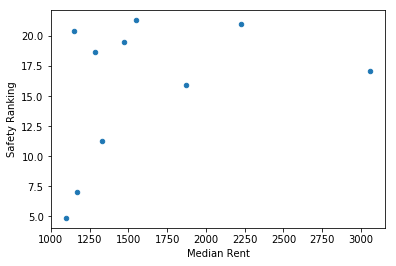

In [183]:
# plot average median rent vs average safety ranking
averages.plot(x='Median Rent', y='Safety Ranking', kind='scatter');

While neighborhood safety tend to increase with median rent prices, especially in clusters such as 2, which contains Bel-Air, San Marino, Palos Verdes, and 8, which is in Long Beach, there are still some areas that are safe and yet very affordable, such as clusters 1, 4, 7, and 10. However, the safest neighborhoods may not always attract young professionals, since most of those neighborhoods are in east LA, in cities such as Pomona, Palmdale, and San Fernando Valley, which is far away from the more lively districts with restaurants and bars. The kind of area that young professionals want to live in probably is a balance between those criteria. 

Silver Lake, which is known to be inhabited by lots of young professionals, offers very cheap average median rent at \\$1166, but only has a average safety ranking of 7. So maybe some would be inclined to live somewhere else that is more expensive and yet still pretty safe, such as anywhere in cluster 6, in cities like West Hollywood, Santa Monica, Culver City, Palms, and Mid-Wilshire. The average rent in those places is ~\\$1800, but is safer than Silver Lake.  

Interestingly, Koreatown is grouped in cluster 1, which has both low rent and high safety ranking. I always thought of Koreatown as somewhere that is safe during the day, but requires caution at night, but maybe the high volume  of restaurants and activities there help to reduce crimes. 

Based on these clustering results, I would recommend any new LA transplants to move to somewhere in west LA (if you can afford it), where the medium to high rental prices is offset by safe neighborhoods and lots of coffee shops, mexican restaurants, and pizza places. Despite the cheap rent, I would not recommend living in the areas surrounding downtown LA due to the high crime rates. Within downtown LA there seems to be no cluster, which is strange. 


In [184]:
final_df.groupby('Cluster')[['1th Most Common Venue', 
                              '2th Most Common Venue', 
                              '3th Most Common Venue',
                              '4th Most Common Venue',
                              '5th Most Common Venue']].agg(lambda x: x.value_counts().index[0])

,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
Cluster,,,,,
1,Mexican Restaurant,Fast Food Restaurant,Fast Food Restaurant,Grocery Store,Convenience Store
2,Sushi Restaurant,Sushi Restaurant,Zoo,Fair,Empanada Restaurant
3,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Park,Park
4,Food,Zoo,Farm,Empanada Restaurant,English Restaurant
5,Lake,Zoo,Falafel Restaurant,Empanada Restaurant,English Restaurant
6,Coffee Shop,Convenience Store,Mexican Restaurant,Pizza Place,Coffee Shop
7,Mexican Restaurant,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Coffee Shop
8,Fishing Spot,American Restaurant,Zoo,Farm,English Restaurant
9,Coffee Shop,Fast Food Restaurant,Coffee Shop,American Restaurant,Café


<a id='conclusion'></a>
## 6. Conclusion 
Where you conclude the report.

After reading this extensive report, I hope you will have a good grasp of the different neighborhoods in LA and have a good idea of where you would want to live if you ever move to LA. Despite LA's sunshine, palm trees and neverending strip malls, LA is a big, big place that actually offers a wide diversity of neighborhoods and caters to people of all backgrounds and lifestyles. If you are a young professional, I hope this guide can help you decide which neighborhood you'd like to live in!
